# Fit Baker data with multiplicative adaptation model with sine-offset responses (MA-S-OFF)

## Original MA model
$$\tau_r \frac{dr}{dt} = -r + (1-a_s)x_sI_s(t) + (1-a_p)x_pI_p(t)$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad\quad\quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t)$$

## MA-S-OFF model

$$\tau_r \frac{dr}{dt} = -r + (1-a_s)x_sI_s(t) + (1-a_p)x_pI_p(t) + (1-a_{q/s})x_{q/s}I_{q/s} + (1-a_{p/s})x_{p/s}I_{p/s}$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad\quad\quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t) \quad\quad\quad \tau_a \frac{da_{q/s}}{dt} = -a_{q/s} + I_{q/s}(t) \quad\quad\quad \tau_a \frac{da_{p/s}}{dt} = -a_{p/s} + I_{p/s}(t)$$

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from aux import get_seg, get_sine_off_cur
from disp import set_font_size

cc = np.concatenate

FPS = 8.5
DT = 1/FPS
NT = 300
T = DT*np.arange(NT) - 10

IT_STIM = (85, 170)
IDUR_STIM = IT_STIM[1] - IT_STIM[0]
DUR_STIM = DT*IDUR_STIM

T_COLS = [f'IT_{it}' for it in range(NT)]

LOAD_FILE = 'data/simple/neur/baker.csv'

In [2]:
# load data
df = pd.read_csv(LOAD_FILE)
expt_ids = np.sort(np.unique(df['EXPT_ID']))

df

,EXPT_ID,STIM,LINE,FLY,ROI,ROI_USED,IT_0,IT_1,IT_2,IT_3,...,IT_290,IT_291,IT_292,IT_293,IT_294,IT_295,IT_296,IT_297,IT_298,IT_299
0,0,S,R70G01,0,somas,False,-0.286139,-0.251529,-0.214845,-0.085881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,P,R70G01,0,somas,False,-0.090690,-0.071585,0.027546,-0.089212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,S,R70G01,1,somas,False,-0.074163,-0.052967,-0.226459,-0.086673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,P,R70G01,1,somas,False,-0.094280,-0.175828,-0.132839,-0.155376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,S,R70G01,2,somas,False,-0.359071,-0.296972,-0.283760,-0.206650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,221,P,vPN1_split,0,somas,False,0.308926,0.069519,-0.028961,-0.103122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444,222,S,vPN1_split,1,somas,False,0.268154,0.517779,0.526319,0.353496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,222,P,vPN1_split,1,somas,False,0.563747,0.506288,0.271983,0.002747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,223,S,vPN1_split,2,somas,False,0.023391,0.023677,0.009701,0.006185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


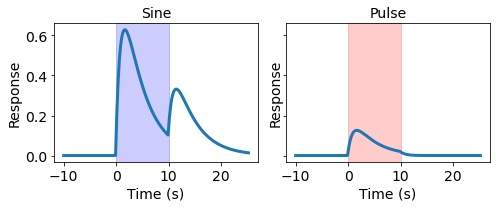

In [3]:
# define smln & obj function
def smlt_ma(tau_r, tau_a, x_s, x_p, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    i_s = np.zeros(NT)
    i_p = np.zeros(NT)
    
    if inp == 's':
        i_s[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
    elif inp == 'p':
        i_p[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
        
    r = np.nan*np.zeros(NT)
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(T[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct])
    
    return r


def smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    x_ps = x_qs
    
    i_s = np.zeros(NT)
    i_p = np.zeros(NT)
    
    if inp == 's':
        i_s[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
    elif inp == 'p':
        i_p[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
        
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
 
    r = np.nan*np.zeros(NT)
    
    r[0] = 0
    a_s, a_p, a_qs, a_ps = 0, 0, 0, 0
    
    for ct, t_ in enumerate(T[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        a_qs += ((DT/tau_a) * (-a_qs + i_qs[ct]))
        a_ps += ((DT/tau_a) * (-a_ps + i_ps[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + (1 - a_qs)*x_qs*i_qs[ct] + (1 - a_ps)*x_ps*i_ps[ct])
    
    return r

# test
r_test_s = smlt_masoff(tau_r=1, tau_a=4, x_s=1, x_p=.2, x_qs=.5, t_0=0, inp='s')
r_test_p = smlt_masoff(tau_r=1, tau_a=4, x_s=1, x_p=.2, x_qs=1, t_0=0, inp='p')

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, tight_layout=True)
axs[0].plot(T, r_test_s, lw=3)
axs[0].set_title('Sine')
axs[1].plot(T, r_test_p, lw=3)
axs[1].set_title('Pulse')

for ax, c in zip(axs, ['b', 'r']):
    ax.axvspan(0, 10, color=c, alpha=.2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Response')
    
set_font_size(axs, 14)

In [4]:
# set initial params
cols_param_0_dyn = ['EXPT_ID', 'T_0', 'R_0', 'TAU_R', 'TAU_A', 'X_S', 'X_P', 'X_QS', 'X_PS']
data_param_0_dyn = [
    {'EXPT_ID': 52, 'T_0': 0, 'R_0': .1, 'TAU_R': 7, 'TAU_A': 100, 'X_S': -3, 'X_P': -3, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 77, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 78, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 79, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 80, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 81, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3.5, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 82, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 104, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 105, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 2, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 106, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 107, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 108, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 109, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 112, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': -3, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 118, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 141, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 13, 'X_P': 2, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 142, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 143, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 144, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 145, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 165, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 5, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 168, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 8, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 171, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 176, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 177, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 183, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 184, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 185, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 201, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 202, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 204, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 205, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 206, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 207, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 208, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    {'EXPT_ID': 210, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
    
    # neurons with sine-offset responses
    {'EXPT_ID': 57, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 2, 'X_S': 10, 'X_P': .1, 'X_QS': 5, 'X_PS': 5},
    {'EXPT_ID': 58, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 20, 'X_S': 10, 'X_P': .1, 'X_QS': 5, 'X_PS': 5},
    {'EXPT_ID': 60, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 20, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 61, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 62, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 20, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 63, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 64, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 65, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 66, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 10, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 67, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': 2, 'X_P': .1, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 74, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': -.5, 'X_P': -.5, 'X_QS': 10, 'X_PS': 10},
    {'EXPT_ID': 98, 'T_0': 0, 'R_0': .1, 'TAU_R': 3, 'TAU_A': 5, 'X_S': -.5, 'X_P': 5, 'X_QS': -5, 'X_PS': -5},
    {'EXPT_ID': 110, 'T_0': 0, 'R_0': .1, 'TAU_R': .3, 'TAU_A': 10, 'X_S': 5, 'X_P': -2, 'X_QS': 5, 'X_PS': 5},
    {'EXPT_ID': 162, 'T_0': 0, 'R_0': .1, 'TAU_R': .3, 'TAU_A': 1, 'X_S': 5, 'X_P': 5, 'X_QS': 3, 'X_PS': 3},
    {'EXPT_ID': 199, 'T_0': 0, 'R_0': .1, 'TAU_R': .3, 'TAU_A': 20, 'X_S': -5, 'X_P': -4, 'X_QS': 5, 'X_PS': 5},
]


EXPT_IDS_SINE_OFF = [57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 74, 98, 110, 162, 199]

df_param_0 = pd.DataFrame(columns=cols_param_0_dyn, data=data_param_0_dyn)
df_param_0.to_csv('data/simple/baker_masoff_fit_param_0.csv', index=False)
df_param_0

,EXPT_ID,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,52,0,0.1,7.0,100.0,-3.0,-3.0,0,0
1,77,0,0.1,0.7,2.0,3.0,10.0,0,0
2,78,0,0.1,0.7,2.0,0.0,10.0,0,0
3,79,0,0.1,1.0,3.0,0.0,10.0,0,0
4,80,0,0.1,1.0,3.0,0.0,10.0,0,0
5,81,0,0.1,1.0,3.5,0.0,10.0,0,0
6,82,0,0.1,0.7,2.0,0.0,10.0,0,0
7,104,0,0.1,0.7,2.0,3.0,10.0,0,0
8,105,0,0.1,0.7,2.0,2.0,10.0,0,0
9,106,0,0.1,0.7,2.0,0.0,10.0,0,0


In [5]:
# objective function for dynamical system fit
def obj_ma(param, t_0, r_s, r_p):
    # unpack parameters (5 total)
    r_0 = param[0]  # y offset
    tau_r, tau_a, x_s, x_p = param[1:]
    
    pred_s = smlt_ma(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
    pred_p = smlt_ma(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
    
    # compute error
    sq_err = np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2)
    
    return sq_err

BDS_OBJ_MA = [(None, None), (.001, None), (.001, None), (None, None), (None, None)]


# objective function for fit with sine-offset responses
def obj_masoff(param, t_0, r_s, r_p):
    # unpack parameters (5 total)
    r_0 = param[0]  # y offset
    tau_r, tau_a, x_s, x_p, x_qs = param[1:]
    
    pred_s = smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, inp='s') + r_0
    pred_p = smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, inp='p') + r_0
    
    # compute error
    sq_err = np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2)
    
    return sq_err

BDS_OBJ_MASOFF = [(None, None), (.001, None), (.001, None), (None, None), (None, None), (None, None)]

In [ ]:
# loop over expt_ids
cols_pred_dyn = df.columns
data_pred_dyn = []

cols_param_dyn = ['EXPT_ID', 'LINE', 'FLY', 'ROI', 'ROI_USED', 'FIT_ERR', 'SUCCESS'] + ['T_0', 'R_0', 'TAU_R', 'TAU_A', 'X_S', 'X_P']
data_param_dyn = []

for expt_id in expt_ids:
# for expt_id in [0, 5, 29, 57, 61, 63, 66, 77, 81, 144]:
    sys.stdout.write('.')
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    line = row_s['LINE']
    fly = row_s['FLY']
    roi = row_s['ROI']
    roi_used = row_s['ROI_USED']
    
    r_s = np.array(row_s[T_COLS])
    r_p = np.array(row_p[T_COLS])
    
    if expt_id not in EXPT_IDS_SINE_OFF:
        # set initial params
        if expt_id in list(df_param_0['EXPT_ID']):
            row_param_0 = df_param_0[df_param_0['EXPT_ID'] == expt_id].iloc[0]
            p_0 = np.array([row_param_0['R_0'], row_param_0['TAU_R'], row_param_0['TAU_A'], row_param_0['X_S'], row_param_0['X_P']])
        else:
            p_0 = np.array([0, 2, 5, 1., 1.])  # r_0, tau_r, tau_a, x_s, x_p

        # fit model
        obj_best = np.inf
        for t_0 in -DT*np.arange(-2, 9):
            fit_rslt = optimize.minimize(obj_ma, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ_MA)  # try default (BFGS) first
            if not fit_rslt.success:  # try Nelder-Mead
                fit_rslt = optimize.minimize(obj_ma, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ_MA, method='Nelder-Mead', options={'maxiter': 1e5})

            if fit_rslt.fun < obj_best:
                fit_rslt_best = copy(fit_rslt)
                t_0_best = t_0

                obj_best = fit_rslt.fun

        fit_rslt = fit_rslt_best
        t_0 = t_0_best

        p_found = fit_rslt.x

        # unpack params
        r_0, tau_r, tau_a, x_s, x_p = p_found
        
        x_qs = 0
        x_ps = 0

        # make predictions
        pred_s = smlt_ma(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
        pred_p = smlt_ma(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
        
    else:
        sys.stdout.write('S-OFF')
        # set initial params
        if expt_id in list(df_param_0['EXPT_ID']):
            row_param_0 = df_param_0[df_param_0['EXPT_ID'] == expt_id].iloc[0]
            p_0 = np.array([row_param_0['R_0'], row_param_0['TAU_R'], row_param_0['TAU_A'], row_param_0['X_S'], row_param_0['X_P'], row_param_0['X_QS']])
        else:
            p_0 = np.array([0, 2, 5, 1., 1., 0])  # r_0, tau_r, tau_a, x_s, x_p, x_qs

        # fit model
        obj_best = np.inf
        for t_0 in -DT*np.arange(-2, 9):
            fit_rslt = optimize.minimize(obj_masoff, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ_MASOFF)  # try default (BFGS) first
            if not fit_rslt.success:  # try Nelder-Mead
                fit_rslt = optimize.minimize(obj_masofflin, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ_MASOFF, method='Nelder-Mead', options={'maxiter': 1e5})

            if fit_rslt.fun < obj_best:
                fit_rslt_best = copy(fit_rslt)
                t_0_best = t_0

                obj_best = fit_rslt.fun

        fit_rslt = fit_rslt_best
        t_0 = t_0_best

        p_found = fit_rslt.x

        # unpack params
        r_0, tau_r, tau_a, x_s, x_p, x_qs = p_found
        
        x_ps = x_qs

        # make predictions
        pred_s = smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, inp='s') + r_0
        pred_p = smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, inp='p') + r_0
        
    
    # store predictions
    pred_dict_s = {'EXPT_ID': expt_id, 'STIM': 'S', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    pred_dict_p = {'EXPT_ID': expt_id, 'STIM': 'P', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    
    # add time cols
    for it, t_col in enumerate(T_COLS):
        pred_dict_s[t_col] = pred_s[it]
        pred_dict_p[t_col] = pred_p[it]
        
    data_pred_dyn.extend([pred_dict_s, pred_dict_p])
    
    # store params
    param_dict = {'EXPT_ID': expt_id, 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    param_dict['FIT_ERR'] = np.sqrt(np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2))
    param_dict['SUCCESS'] = fit_rslt.success
    param_dict['T_0'] = t_0
    param_dict['R_0'] = r_0
    param_dict['TAU_R'] = tau_r
    param_dict['TAU_A'] = tau_a
    param_dict['X_S'] = x_s
    param_dict['X_P'] = x_p
    param_dict['X_QS'] = x_qs
    param_dict['X_PS'] = x_ps
    
    data_param_dyn.append(param_dict)

.............................................

In [ ]:
df_param_dyn = pd.DataFrame(columns=cols_param_dyn, data=data_param_dyn)
df_pred_dyn = pd.DataFrame(columns=cols_pred_dyn, data=data_pred_dyn)

In [ ]:
df_param_dyn.to_csv('data/simple/baker_masoff_fit_param.csv', index=False)
df_pred_dyn.to_csv('data/simple/baker_masoff_fit_pred.csv', index=False)

# Examine fits

In [ ]:
df_param_0 = pd.read_csv('data/simple/baker_masoff_fit_param_0.csv')

df_param_dyn = pd.read_csv('data/simple/baker_masoff_fit_param.csv')
df_pred_dyn = pd.read_csv('data/simple/baker_masoff_fit_pred.csv')

In [ ]:
df_param_0

In [ ]:
df_param_dyn

In [ ]:
df_pred_dyn

In [ ]:
# subset of ROIs
expt_ids_plot = [0, 5, 29, 57, 61, 63, 66, 77, 81, 144]
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # saved prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
    # prediction simulated from initial parameters
    if expt_id in list(df_param_0['EXPT_ID']):
        t_0 = df_param_0['T_0'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        r_0 = df_param_0['R_0'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        tau_r = df_param_0['TAU_R'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        tau_a = df_param_0['TAU_A'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        x_s = df_param_0['X_S'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        x_p = df_param_0['X_P'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        x_qs = df_param_0['X_QS'][df_param_0['EXPT_ID'] == expt_id].iloc[0]
        x_ps = df_param_0['X_PS'][df_param_0['EXPT_ID'] == expt_id].iloc[0]

        ## sine response
        axs[0].plot(T, smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, 's') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')
        ## pulse response
        axs[1].plot(T, smlt_masoff(tau_r, tau_a, x_s, x_p, x_qs, t_0, 'p') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')

axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

In [ ]:
# all ROIs
nroi_plot = 224
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids[:nroi_plot]):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # saved prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)